# Pneumococcal Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import chisquare, chi2_contingency

In [2]:
HOME_DIR = "/Users/martinemons/polybox/Universitaet/MSc_CBB/FS2021/IDD-rotation/IDD_TB"

In [3]:
df = pd.read_csv(HOME_DIR + "/data/PneumoData.csv")

#### unchanged dataframe

In [4]:
df

,Accession,Strain Name,Taxon ID,Strain Cluster (SC),Year of Isolation,Community of Isolation,Host Age (months),Serotype,Capsule locus,Consensus serotype,Sequence type,Inferred sequence type,Benzylpenicillin MIC (_g/mL),Ceftriaxone MIC (_g/mL),Trimethoprim MIC (_g/mL),Erythromycin MIC (_g/mL),Tetracycline MIC (_g/mL),Chloramphenicol MIC (_g/mL)
0,ERR129088,CH2079,5Z52R,1,2007,C,Jun-24,10A,10A,10A,816.0,816,0.023,0.023,0.125,0.064,NaN,NaN
1,ERR129126,LE4000,N5O68,1,2007,D,24-36,10A,10A,10A,3290.0,3290,0.023,0.023,0.094,0.094,NaN,NaN
2,ERR129158,LE4124,RUJ90,1,2007,D,24-36,10A,10A,10A,816.0,816,0.023,0.023,0.19,0.047,NaN,NaN
3,ERR129164,MD5021,29ORI,1,2007,E,Jun-24,10A,10A,10A,816.0,816,0.032,0.032,0.125,0.064,NaN,NaN
4,ERR129199,ND6034,RN3X8,1,2007,F,36-84,10A,10A,10A,816.0,816,0.023,0.032,0.25,0.094,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,ERR069838,388483,388483,16,2001,H,36-84,6B,NT,6B,146.0,146,0.25,0.5,>4/76,>1,0.25,NaN
612,ERR069840,397079,397079,16,2001,J,36-84,6B,6A,6B,315.0,315,0.25,0.06,0.5/9.,>1,>8,NaN
613,ERR065957,436154,436154,16,2001,P,Jun-24,6B,6A,6B,1954.0,1954,1,0.5,0.25/4,<0.03,0.12,NaN
614,ERR069769,132571,132571,16,2001,N,Jun-24,9N,9N,9N,405.0,405,<0.03,<0.03,0.25/4,<0.03,0.25,NaN


### Data Wrangling

In the early 2000's the Prevnar vaccine was approved by the FDA for usage in children. It is a vaccine agains *Streptococcus pneumoniae*. It targets the serotypes 4, 6B, 9V, 14, 18C, 19F, and 23F according to the FDA. These serotypes included in the vaccine are the vaccine types, all the rest is the non-vaccine-type

#### define the non-vaccine types vs the vaccine types

In [5]:
#set all the types included in the Prevnar Vaccine to be the vaccine-type
dic = {'4': 'vaccine-type', '6B': 'vaccine-type', '9V': 'vaccine-type', '14': 'vaccine-type', '18C': 'vaccine-type', '19F': 'vaccine-type', '23F': 'vaccine-type'}

#then set all to be non-vaccine that are infected with the strains included in the Prevnar vaccine
df['Vaccine-type'] = df['Serotype'].map(dic) 

#set the rest (denoted as NaN) to be vaccinated
df['Vaccine-type'] = df['Vaccine-type'].fillna('non-vaccine-type')

one can define whether the pneumococcal isolate is resistant or sensitive whether the minimum inhibitory concentration (MIC) is above or below a certain threshold. We will perform this analysis first for a single antibiotic, namely benzylpenicillin. An MIC for benzylpenicillin above 0.06 is considered as being resistant. This step was commented out and in the actual code the MICs for benzylpenicillin, Ceftriaxone, Trimethoprim and Erythromycin were used. Whenever one MIC of these four antibiotics was above the given threshold, the sample was being calssified as resistant.

In [6]:
#prior setting everything to sensitive
df['Resistance-type'] = np.repeat('sensitive', 616)

In [7]:
#some weird data points were inexistant, those were set to 0 manually for the time being

#fill NaN with an arbitrary high number so that they can be converted into floats. Later before the MIC comparison I will set them to None
df = df.fillna(1234)

#some values of Benzylpenzicillin were empty instead of NaN, those were set to be zero
df.iloc[336,12] = 1234

df.iloc[423,12] = 1234

df.iloc[516,12] = 1234

df.iloc[523,12] = 1234

df.iloc[558,12] = 1234

In [8]:
#loop over the antibiotic MICs that start in column 12 and end in column 15
for i in range(12,16): 
    #convert into strings in order to perform string cutting and splitting operations
    df.iloc[:,i] = df.iloc[:,i].astype(str)

    #cutting away the '<' and '<=' and Dates(?!?) in the concentration field.
    df.iloc[:,i] = df.iloc[:,i].map(lambda x: x.lstrip('<>=AprFebJan-'))
    df.iloc[:,i] = df.iloc[:,i].map(lambda x: x.rstrip('/'))
    #loop over all the datapoints in the rows
    for j in range (616):

        #mapping every entry back to a float for those values that could be converted
        try:
            df.iloc[j,i] = float(df.iloc[j,i])
        except:
            #wrote an exception if the number has written as e.g. "0.25/7" to get the correct transformation into a decimal as splitting and then                               dividing
            t = df.iloc[j,i].split('/')
            #print(t)
            df.iloc[j,i] = float(t[0])/float(t[1])
        
  

In [9]:
df

,Accession,Strain Name,Taxon ID,Strain Cluster (SC),Year of Isolation,Community of Isolation,Host Age (months),Serotype,Capsule locus,Consensus serotype,Sequence type,Inferred sequence type,Benzylpenicillin MIC (_g/mL),Ceftriaxone MIC (_g/mL),Trimethoprim MIC (_g/mL),Erythromycin MIC (_g/mL),Tetracycline MIC (_g/mL),Chloramphenicol MIC (_g/mL),Vaccine-type,Resistance-type
0,ERR129088,CH2079,5Z52R,1,2007,C,Jun-24,10A,10A,10A,816.0,816,0.023,0.023,0.125,0.064,1234,1234,non-vaccine-type,sensitive
1,ERR129126,LE4000,N5O68,1,2007,D,24-36,10A,10A,10A,3290.0,3290,0.023,0.023,0.094,0.094,1234,1234,non-vaccine-type,sensitive
2,ERR129158,LE4124,RUJ90,1,2007,D,24-36,10A,10A,10A,816.0,816,0.023,0.023,0.19,0.047,1234,1234,non-vaccine-type,sensitive
3,ERR129164,MD5021,29ORI,1,2007,E,Jun-24,10A,10A,10A,816.0,816,0.032,0.032,0.125,0.064,1234,1234,non-vaccine-type,sensitive
4,ERR129199,ND6034,RN3X8,1,2007,F,36-84,10A,10A,10A,816.0,816,0.023,0.032,0.25,0.094,1234,1234,non-vaccine-type,sensitive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,ERR069838,388483,388483,16,2001,H,36-84,6B,NT,6B,146.0,146,0.25,0.5,0.052632,1.0,0.25,1234,vaccine-type,sensitive
612,ERR069840,397079,397079,16,2001,J,36-84,6B,6A,6B,315.0,315,0.25,0.06,0.055556,1.0,>8,1234,vaccine-type,sensitive
613,ERR065957,436154,436154,16,2001,P,Jun-24,6B,6A,6B,1954.0,1954,1.0,0.5,0.0625,0.03,0.12,1234,vaccine-type,sensitive
614,ERR069769,132571,132571,16,2001,N,Jun-24,9N,9N,9N,405.0,405,0.03,0.03,0.0625,0.03,0.25,1234,non-vaccine-type,sensitive


In [10]:
# set the Nans that were converted to an arbitrary number for the string conversions now to None again
for i in range(12,18):
    for j in range (616):
        if df.iloc[j,i] == 1234:
            df.iloc[j,i] = 'NaN'

In [12]:
#the MIC for the antibiotics as given by the ordering of the dataframe
MIC = np.array([0.06, 0.5, 1, 0.25])
#going through all the MICs and check whether these make for a resistant phenotype
for i in range(12,16):
    for j in range (616):
        if df.iloc[j,i] == 'NaN':
            continue
        #check whether the MIC is higher than the threshold defined above
        if df.iloc[j,i] > MIC[i-12]:
            #if yes, then change the column "Resistance-type" from sensitive to resistant
            df.iloc[j,19] = 'resistant'

In [13]:
#dataframe with the cleaned MICs all in float format or 0 if not available and the classification as being either sensitive or resistant
df

,Accession,Strain Name,Taxon ID,Strain Cluster (SC),Year of Isolation,Community of Isolation,Host Age (months),Serotype,Capsule locus,Consensus serotype,Sequence type,Inferred sequence type,Benzylpenicillin MIC (_g/mL),Ceftriaxone MIC (_g/mL),Trimethoprim MIC (_g/mL),Erythromycin MIC (_g/mL),Tetracycline MIC (_g/mL),Chloramphenicol MIC (_g/mL),Vaccine-type,Resistance-type
0,ERR129088,CH2079,5Z52R,1,2007,C,Jun-24,10A,10A,10A,816.0,816,0.023,0.023,0.125,0.064,NaN,NaN,non-vaccine-type,sensitive
1,ERR129126,LE4000,N5O68,1,2007,D,24-36,10A,10A,10A,3290.0,3290,0.023,0.023,0.094,0.094,NaN,NaN,non-vaccine-type,sensitive
2,ERR129158,LE4124,RUJ90,1,2007,D,24-36,10A,10A,10A,816.0,816,0.023,0.023,0.19,0.047,NaN,NaN,non-vaccine-type,sensitive
3,ERR129164,MD5021,29ORI,1,2007,E,Jun-24,10A,10A,10A,816.0,816,0.032,0.032,0.125,0.064,NaN,NaN,non-vaccine-type,sensitive
4,ERR129199,ND6034,RN3X8,1,2007,F,36-84,10A,10A,10A,816.0,816,0.023,0.032,0.25,0.094,NaN,NaN,non-vaccine-type,sensitive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,ERR069838,388483,388483,16,2001,H,36-84,6B,NT,6B,146.0,146,0.25,0.5,0.052632,1.0,0.25,NaN,vaccine-type,resistant
612,ERR069840,397079,397079,16,2001,J,36-84,6B,6A,6B,315.0,315,0.25,0.06,0.055556,1.0,>8,NaN,vaccine-type,resistant
613,ERR065957,436154,436154,16,2001,P,Jun-24,6B,6A,6B,1954.0,1954,1.0,0.5,0.0625,0.03,0.12,NaN,vaccine-type,resistant
614,ERR069769,132571,132571,16,2001,N,Jun-24,9N,9N,9N,405.0,405,0.03,0.03,0.0625,0.03,0.25,NaN,non-vaccine-type,sensitive


now the idea is to take a subset of the data, the non-vaccinated individuals, and make the rest of the inference based on these. The question we are asking how does antibiotic resistance behave in the non-vaccinated group after we reduced the amount of available host via vaccination.

In [14]:
#counting how many vaccinated vs non vaccinated individuals there are and we see that the dataset is quite skewed
df['Vaccine-type'].value_counts()

non-vaccine-type    537
vaccine-type         79
Name: Vaccine-type, dtype: int64

In [15]:
#group by year of isolation and vaccine type then count the occurences per year
df_vacc_type_freq = df.groupby(['Year of Isolation', 'Vaccine-type']).size().reset_index()

#rename the columns
df_vacc_type_freq.columns = ['Year of Isolation', 'Vaccine-type', 'Counts']

In [16]:
df_vacc_type_freq

,Year of Isolation,Vaccine-type,Counts
0,2001,non-vaccine-type,93
1,2001,vaccine-type,40
2,2004,non-vaccine-type,174
3,2004,vaccine-type,29
4,2007,non-vaccine-type,270
5,2007,vaccine-type,10


### Analysis of Vaccine-types vs. non-vaccine-types over the years

As the overall positivty rate chang over the years, we wanted to account for that by dividing the counts by the number of positive tests in that respective year. Like this we get a rate per positive test which is a quantity we can compare.

In [17]:
total = np.array([0,0,0])

total [0] = df_vacc_type_freq['Counts'][0] + df_vacc_type_freq['Counts'][1]
total [1] = df_vacc_type_freq['Counts'][2] + df_vacc_type_freq['Counts'][3]
total [2] = df_vacc_type_freq['Counts'][4] + df_vacc_type_freq['Counts'][5]

#we know that the positive rates were 27%, 23% and 30% for 2001,2004 and 2007 respectively
positivity = np.array([1/0.27,1/0.23,1/0.3])

#calculate how many people were tested in total
for i in range(3):
        total[i] = total[i] * positivity[i]
total = pd.DataFrame(np.repeat(total,2,axis=0))

In [18]:
total

,0
0,492
1,492
2,882
3,882
4,933
5,933


In [19]:
#calculate the relative frequencies for vaccine type per number of positive tests
df_vacc_type_freq['Relative-frequencies'] = df_vacc_type_freq['Counts']/total[0]

In [20]:
df_vacc_type_freq

,Year of Isolation,Vaccine-type,Counts,Relative-frequencies
0,2001,non-vaccine-type,93,0.189024
1,2001,vaccine-type,40,0.081301
2,2004,non-vaccine-type,174,0.197279
3,2004,vaccine-type,29,0.032880
4,2007,non-vaccine-type,270,0.289389
5,2007,vaccine-type,10,0.010718


In [21]:
#plot of the absolute counts as a bar plot

fig = px.bar(df_vacc_type_freq, x='Year of Isolation', y = 'Relative-frequencies',  color = 'Vaccine-type',  barmode='group', labels={'Relative-frequencies': 'Relative-frequencies/positive case'}, title = 'Relative-frequencies of Vaccine-types')
fig.show()

We see that in the year 2001, immediatley after the start of the vaccination campaign, we have more non-vaccine type than vaccine-type infections. What can be seen as well is that first the vaccine-type strains start to decrease before the non-vaccine-type strains increase.

### Analysis of the initial frequencies of vaccine-type strains

In [36]:
df_vacc = df[df['Vaccine-type']=='vaccine-type']

In [37]:
#count the occurence of sensitive and resistant over all in the vaccinate-type group
df_vacc['Resistance-type'].value_counts()

sensitive    40
resistant    39
Name: Resistance-type, dtype: int64

In [40]:
contigency_vacc = pd.crosstab(df_vacc['Year of Isolation'], df_vacc['Resistance-type'])

In [41]:
contigency_vacc

Resistance-type,resistant,sensitive
Year of Isolation,,
2001,20,20
2004,16,13
2007,3,7


### Analysis of the non-vaccine-types and their resistance types

In [22]:
#select those individuals where the vaccine-type is non-vaccinated
df_nonvacc = df[df['Vaccine-type']=='non-vaccine-type']

In [23]:
#count the occurence of sensitive and resistant over all
df_nonvacc['Resistance-type'].value_counts()

sensitive    311
resistant    226
Name: Resistance-type, dtype: int64

In [24]:
#group by year of isolation and resistance type then count the occurences of sensitive and resistant per year
df_nonvacc_freq = df_nonvacc.groupby(['Year of Isolation', 'Resistance-type']).size().reset_index()

#rename the columns
df_nonvacc_freq.columns = ['Year of Isolation', 'Resistance-type', 'Counts']

In [25]:
#in order to normalise the counts and get relative frequencies
norm = df_nonvacc['Year of Isolation'].value_counts()
norm = pd.DataFrame(np.flip(np.array(norm)))

print(norm)

newdf = pd.DataFrame(np.repeat(norm.values,2,axis=0))
newdf.columns = ['norm']

#actual normalisation
df_nonvacc_freq['Relative Frequencies'] = df_nonvacc_freq['Counts']/newdf['norm']

     0
0   93
1  174
2  270


In [26]:
#dataframe with the counts and relative frequencies per year and per resistance type
df_nonvacc_freq

,Year of Isolation,Resistance-type,Counts,Relative Frequencies
0,2001,resistant,35,0.376344
1,2001,sensitive,58,0.623656
2,2004,resistant,74,0.425287
3,2004,sensitive,100,0.574713
4,2007,resistant,117,0.433333
5,2007,sensitive,153,0.566667


#### Plotting the Results

In [27]:
#plot of the absolute counts as a bar plot

fig = px.bar(df_nonvacc_freq, x='Year of Isolation', y = 'Counts',  color = 'Resistance-type',  barmode='group', title = 'Absolute counts of non-vaccinated subtypes, n = {93, 174, 270}')
fig.show()

In [28]:
#plot of the relative frequencies as a bar plot

fig = px.bar(df_nonvacc_freq, x = 'Year of Isolation', y = 'Relative Frequencies',  color = 'Resistance-type', barmode='group', title = 'Relative Frequencies of non-vaccinated subtypes, n = {93, 174, 270}')
fig.show()

In [29]:
#plot of the relative frequencies as a scatter plot

fig = px.scatter(df_nonvacc_freq, x = 'Year of Isolation', y = 'Relative Frequencies',  color = 'Resistance-type', title = 'Relative Frequencies of non-vaccinated subtypes, n = {93, 174, 270}')
fig.show()

#### Statistical Analysis

In [30]:
contigency = pd.crosstab(df_nonvacc['Year of Isolation'], df_nonvacc['Resistance-type'])

In [31]:
contigency

Resistance-type,resistant,sensitive
Year of Isolation,,
2001,35,58
2004,74,100
2007,117,153


<AxesSubplot:xlabel='Resistance-type', ylabel='Year of Isolation'>

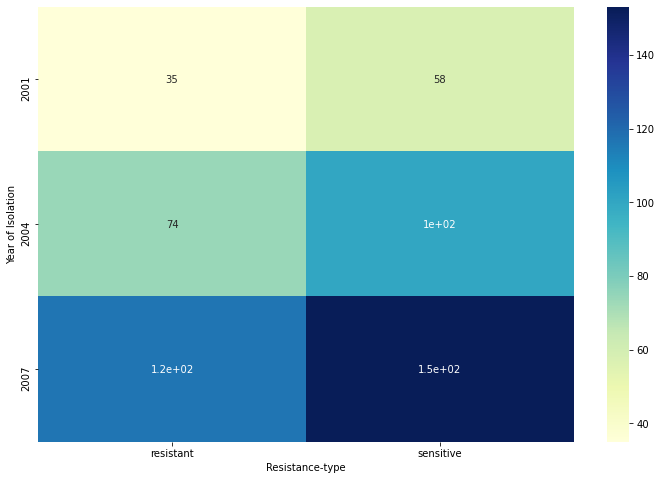

In [32]:
plt.figure(figsize=(12,8))
sns.heatmap(contigency, annot=True, cmap="YlGnBu")

In [33]:
# chi square test on the contingency table
chi2_contingency(contigency)

(0.9424665715861007,
 0.6242319369815674,
 2,
 array([[ 39.1396648 ,  53.8603352 ],
        [ 73.22905028, 100.77094972],
        [113.63128492, 156.36871508]]))

what we see in analysing the the relative proportions and the absolute counts of the non-vaccine type strains is the following:
* the overall counts increase over the year - there was more testing 
* when looking at the relative counts we see that we have a trend of increase in resistance and a decrease of sensitivity
* these findings are though not significant in any sense, we can only talk about a trend